# CHAPTER 0 - INTRODUCTION

## Python Project - Samuele Ceol 
A case study on the correlation between the labour market and suicide rates in Europe

In [1]:
# This block contains all the libraries used in this notebook
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import seaborn as sns
import pycountry
import pickle 
import joblib

from scipy import stats
from matplotlib.colors import DivergingNorm
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

Before starting with our project, we will use the following code block to define some attributes that we will use in multiple places throughout our notebook.

A list containing the names of all european countries is defined, it will be later used for filtering purposes.

A function to perform some basic operation on OECD data is also defined here.

In [58]:
euro_countries = ['Ukraine','France','Spain','Sweden','Norway','Germany','Finland','Poland','Italy','United Kingdom','Romania','Belarus','Greece','Bulgaria','Iceland','Hungary','Portugal','Austria','Czechia','Serbia','Ireland','Lithuania','Latvia','Croatia','Bosnia and Herzegovina','Slovakia','Estonia','Denmark','Switzerland','Netherlands','Moldova','Belgium','Armenia','Albania','North Macedonia','Turkey','Slovenia','Montenegro','Kosovo','Azerbaijan','Cyprus','Luxembourg','Georgia','Andorra','Malta','Liechtenstein','San Marino','Monaco','Vatican City']

sns.set_style("white")

def OECD_prepare_data(data, value, drop_sex=True):
    # Drop unused columns
    drop_columns = ['INDICATOR', 'MEASURE', 'FREQUENCY', 'Flag Codes']

    if(drop_sex == True):
        drop_columns = np.append(drop_columns, 'SUBJECT')

    data = data.drop(drop_columns, axis=1)

    # Rename columns
    if(drop_sex == True):
        data.columns = ['country', 'year', value]
    else:
        data.columns = ['country', 'sex', 'year', value]

    # Modify sex column content
    if(drop_sex == False):
        data['sex'] = data['sex'].replace('TOT', 'total').replace('MEN', 'male').replace('WOMEN', 'female')

    return data

# CHAPTER 1 - DATA CURATION

## OECD Suicide Data - Description

We will start off our project by importing the OECD data related to the european suicide rates.

For the OECD data we have three distinct files, one for males, one for females and one containing aggregate data.

No age group sub-division is provided.

The column LOCATION identifies the interested country with a unique two or three letter abbreviation.

Suicide rates are indicated as nr of suicides per 100.000 people.

In [59]:
suicide_tot = pd.read_csv('./source/suicide/OECD_suicides_total.csv')
suicide_male = pd.read_csv('./source/suicide/OECD_suicides_male.csv')
suicide_female = pd.read_csv('./source/suicide/OECD_suicides_female.csv')

To familiarize ourselves with this data, we can display some information associated with it.

In [60]:
suicide_tot.shape

(1955, 8)

In [61]:
suicide_tot.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,SUICIDE,TOT,100000PER,A,1960,13.1,NaN
1,AUS,SUICIDE,TOT,100000PER,A,1961,14.5,NaN
2,AUS,SUICIDE,TOT,100000PER,A,1962,16.9,NaN
3,AUS,SUICIDE,TOT,100000PER,A,1963,19.2,NaN
4,AUS,SUICIDE,TOT,100000PER,A,1964,17.8,NaN


## Note on flag codes

Certain rows in the OECD dataset are marked with flag codes. The meaning of said codes goes as follows:

E = Estimated values

P = Provisional data

B = Break in series

For the purpose of this project we have decided to keep rows containing estimated values and provisional data.

A break in series occurs when data collected in a specific year is not completely comparable with the other rows belonging to the same country. This can occur because the way in which data has been measured or gathered during the flagged years may be partially different in comparison to the rows not flagged with this code.

Since the suicide rates coming from these rows seems to be more or less in line to the surrounding years, we have also decided to keep it.

## OECD Suicide Data - Required actions

We would like to join this three different entities into a single dataframe.

Since they all posses the same columns, we can simply concatenate them.

In [65]:
OECD_suicide = pd.concat([suicide_tot, suicide_male, suicide_female])

We can now modify the content of the SUBJECT column to make it more easibly understandable.

We can also discard the INDICATOR, SUBJECT, MEASURE, FREQUENCY and Flag Codes columns since they are merely descriptive and not needed for our analysis.

Finally, we can rename the Value column into suicide_rate.

In [66]:
OECD_suicide = OECD_prepare_data(OECD_suicide, 'suicide_rate', False)

To join the OECD dataset with the one provided by the World Health Organization and to improve readability, we want to change the three letters identifiers that are currently used into their corresponding full country names.
To do this, we use the pycountry library.

In [67]:
OECD_suicide['country'] = OECD_suicide['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name 
    if len(x) == 3 
    else pycountry.countries.get(alpha_2=x).name
)

We can now filter out the countries in the dataset that are not in Europe.

In order to do this, we will use the list that we have defined at the beginning of this notebook.

In [68]:
print('Initial nr of countries: ')
print(OECD_suicide['country'].nunique())

OECD_suicide = OECD_suicide[OECD_suicide['country'].isin(euro_countries)]

print('Final nr of countries: ')
print(OECD_suicide['country'].nunique())

#List of european countries that are not present in this dataset
print('European countries not present in this dataset: ')
print([x for x in euro_countries if x not in OECD_suicide['country'].unique().tolist()])

Initial nr of countries: 
41
Final nr of countries: 
27
European countries not present in this dataset: 
['Ukraine', 'Romania', 'Belarus', 'Bulgaria', 'Serbia', 'Croatia', 'Bosnia and Herzegovina', 'Moldova', 'Armenia', 'Albania', 'North Macedonia', 'Montenegro', 'Kosovo', 'Azerbaijan', 'Cyprus', 'Georgia', 'Andorra', 'Malta', 'Liechtenstein', 'San Marino', 'Monaco', 'Vatican City']


We can finally rename the remaining columns and see how the dataframe looks like.

TODO - Maintain the groupby even though we don't have duplicates

In [69]:
OECD_suicide = OECD_suicide.sort_values(['country', 'year','sex']).reset_index(drop = True)

We can now see how our cleaned dataset looks like.

In [71]:
OECD_suicide.shape

(3903, 4)

In [72]:
OECD_suicide.head()

,country,sex,year,suicide_rate
0,Austria,female,1960,14.7
1,Austria,male,1960,36.6
2,Austria,total,1960,24.2
3,Austria,female,1961,13.7
4,Austria,male,1961,35.5


In [73]:
print('Number of countries in OECD dataset: ' + str(OECD_suicide['country'].nunique()))

Number of countries in OECD dataset: 27


## WHO Suicide Data - Description

For the data provided by the World Health Organization we have a single file containing information for males and females with a further division by age group.

Suicide values are stored as totals unlike the previous dataframe where they were stored in relation to nr of suicides per 100.000 citizens.

The dataframe also contains information related to the total population of the country for every given year.


In [74]:
WHO_suicide = pd.read_csv('./source/suicide/WHO_suicides_aggregate.csv')

Just like we did with the OECD dataset, we will first print some general information.

In [75]:
WHO_suicide.shape

(43776, 6)

In [76]:
WHO_suicide.head()

,country,year,sex,age,suicides_no,population
0,Albania,1985,female,15-24 years,NaN,277900.0
1,Albania,1985,female,25-34 years,NaN,246800.0
2,Albania,1985,female,35-54 years,NaN,267500.0
3,Albania,1985,female,5-14 years,NaN,298300.0
4,Albania,1985,female,55-74 years,NaN,138700.0


## WHO Suicide Data - Required actions

Once again, we can filter out the countries that are not in Europe.

In [77]:
print('Initial nr of countries: ')
print(WHO_suicide['country'].nunique())

WHO_suicide = WHO_suicide[WHO_suicide['country'].isin(euro_countries)]

print('Final nr of countries: ')
print(WHO_suicide['country'].nunique())

#List of european countries that are not present in this dataset
print('European countries not present in this dataset: ')
print([x for x in euro_countries if x not in WHO_suicide['country'].unique().tolist()])

Initial nr of countries: 
141
Final nr of countries: 
42
European countries not present in this dataset: 
['Czechia', 'Moldova', 'North Macedonia', 'Kosovo', 'Andorra', 'Liechtenstein', 'Vatican City']


We can also rename the suicide_no column and drop the rows in which suicide data is not present.

Note: Although we are renaming the suicides_no column in this block, the calculation to convert the column values to suicide rates will happen later on in this chapter.

In [79]:
WHO_suicide = WHO_suicide.rename(columns={'suicides_no': 'suicide_rate'})

WHO_suicide = WHO_suicide[WHO_suicide['suicide_rate'].notna()]

For our analysis, we are not considering the differences between age groups (given the fact that they are not present in the OECD dataset).

Because of this reason, we can drop the 'age' column and sum population and suicide numbers belonging to the same country, year and sex.


In [80]:
WHO_suicide = WHO_suicide.drop('age', axis=1).groupby(['country', 'year', 'sex']).sum().unstack()

Since this time the dataframe only has a division between males and females, we want to add a new category for the total values which contains the sum for both nr of suicides between males and females and values of the total population.

To facilitate this process, we compute the totals for suicides numbers and population in two different variables and then merge them.

In [81]:
WHO_suicide_mf      = WHO_suicide['suicide_rate'].assign(total=WHO_suicide['suicide_rate'].sum(1)).stack(level='sex')
WHO_population_mf   = WHO_suicide['population'].assign(total=WHO_suicide['population'].sum(1)).stack(level='sex')

WHO_suicide = pd.DataFrame(
    pd.concat(
        [WHO_suicide_mf, WHO_population_mf], 
        axis=1
    ).to_records()).rename(columns = {'0':'suicide_rate', '1':'population'}
) 

Before converting the suicide nr to suicide rates, we should first address the few rows with missing population data.

My initial idea was to use The World Bank census data in order to fill in the gaps in the poulation numbers for the WHO dataset.

The following (now commented) code, was used to drop the columns that were not needed, pivot longer the year columns and filter out the non european countries.

In [20]:
'''
census_tot      = pd.read_csv('./source/census_total.csv').drop(['Country Code', 'Indicator Code'], axis=1)
census_male     = pd.read_csv('./source/census_male.csv').drop(['Country Code', 'Indicator Code'], axis=1)
census_female   = pd.read_csv('./source/census_female.csv').drop(['Country Code', 'Indicator Code'], axis=1)

census = pd.concat([census_tot, census_male, census_female])

census = pd.melt(
    census, 
    id_vars = ['Country Name', 'Indicator Name'], 
    value_vars = [str(i).zfill(4) for i in range(1960,2020)], 
    var_name='year', 
    value_name='population'
).sort_values(
    ['Country Name', 'year', 'Indicator Name']
)

census = census[census['Country Name'].isin(euro_countries)]
census
'''

"\ncensus_tot      = pd.read_csv('./source/census_total.csv').drop(['Country Code', 'Indicator Code'], axis=1)\ncensus_male     = pd.read_csv('./source/census_male.csv').drop(['Country Code', 'Indicator Code'], axis=1)\ncensus_female   = pd.read_csv('./source/census_female.csv').drop(['Country Code', 'Indicator Code'], axis=1)\n\ncensus = pd.concat([census_tot, census_male, census_female])\n\ncensus = pd.melt(\n    census, \n    id_vars = ['Country Name', 'Indicator Name'], \n    value_vars = [str(i).zfill(4) for i in range(1960,2020)], \n    var_name='year', \n    value_name='population'\n).sort_values(\n    ['Country Name', 'year', 'Indicator Name']\n)\n\ncensus = census[census['Country Name'].isin(euro_countries)]\ncensus\n"

I later realized that only 9 rows, out of the total 3759, were missing this data and that the two interested countries (Monaco and San Marino) were missing this data also in the census dataset.

Given the small amount of interested rows, we can drop them without compromising our data.

In [82]:
WHO_suicide = WHO_suicide[WHO_suicide['population'] != 0]

We can now convert the suicide values to suicides per 100.000 people and then drop the population column.

Suicide rate = (Nr of suicides / population) * 100.000

In [83]:
WHO_suicide['suicide_rate'] = ((WHO_suicide['suicide_rate'] / WHO_suicide['population']) * 100000).round(1)
WHO_suicide = WHO_suicide.drop('population', axis=1)

Once again, we can see how the cleaned dataset look like

In [85]:
WHO_suicide.shape

(3549, 4)

In [86]:
WHO_suicide.head()

,country,year,sex,suicide_rate
0,Albania,1987,female,1.9
1,Albania,1987,male,3.4
2,Albania,1987,total,2.7
3,Albania,1988,female,1.6
4,Albania,1988,male,2.9


In [87]:
print('Number of countries in WHO dataset: ' + str(WHO_suicide['country'].nunique()))

Number of countries in WHO dataset: 41


## Suicide data - Merging the two datasets

We are now ready to combine the data coming from the two sources (WHO and OECD).

In case we have rows with the same country, year and sex, we will compute the mean value for the suicide rate among the two datasets.

In [88]:
suicide = pd.concat([OECD_suicide, WHO_suicide]).groupby(['country', 'year', 'sex']).mean().reset_index().sort_values(['country', 'year','sex']).reset_index(drop=True)

print('Shape of OECD data: ' + str(OECD_suicide.shape))
print('Shape of WHO data: ' + str(WHO_suicide.shape))
print('Shape of final suicide dataset: ' + str(suicide.shape))

print('Nr of countries in the final dataset: ' + str(suicide['country'].nunique()))

Shape of OECD data: (3903, 4)
Shape of WHO data: (3549, 4)
Shape of final suicide dataset: (4986, 4)
Nr of countries in the final dataset: 42


In [89]:
suicide.head()

,country,year,sex,suicide_rate
0,Albania,1987,female,1.9
1,Albania,1987,male,3.4
2,Albania,1987,total,2.7
3,Albania,1988,female,1.6
4,Albania,1988,male,2.9


## Suicide data - Contextualizing Outliers

In this sub-chapter, we will try to identify outliers in our suicide dataset by using the z score value.

We don't necessarily want to remove the outliers, but we should be able to at least identify and contextualize them.

A brief definition of the z score goes as follows: "The Z-score is the signed number of standard deviations by which the value of an observation or data point is above (or below) the mean value of what is being observed or measured".

In the following code block, we would like to identify rows with a z-score smaller than -3 or bigger than 3 (i.e. values that are at least 3 standard deviations from the mean)

In [90]:
df = suicide.copy()
df['zscore'] = (suicide.suicide_rate - suicide.suicide_rate.mean()) / suicide.suicide_rate.std()

print('z-score bigger than +3: ' + str(len(df[df['zscore'] > 3])))
print('z-score smaller than -3: ' + str(len(df[df['zscore'] < -3])))

z-score bigger than +3: 92
z-score smaller than -3: 0


We can now print out the number of outliers divided by sex and a list of the countries containing outliers.

Since there are no zscores smaller than -3, we can just work with the ones bigger than 3 for our next steps.

In [92]:
outlier_rows = df[df['zscore'] > 3]

print('Number of male outliers: ' + str(len(outlier_rows[outlier_rows['sex'] == 'male'])))
print('Number of female outliers: ' + str(len(outlier_rows[outlier_rows['sex'] == 'female'])))

outliers_countries = outlier_rows['country'].unique()
print('Countries containing outliers: ' + str(outliers_countries))

Number of male outliers: 92
Number of female outliers: 0
Countries containing outliers: ['Belarus' 'Estonia' 'Hungary' 'Latvia' 'Lithuania' 'Slovenia' 'Ukraine']


Now we can try isolate our countries into two different dataframes, one will have only data from countries that contain rows with outliers, the other will contain the data of the remaining countries.

In order to visualize how the zscores are changing for these countries troughout the years (and to try provide an explanation for this change) we will plot an heatmap of the interested countries.

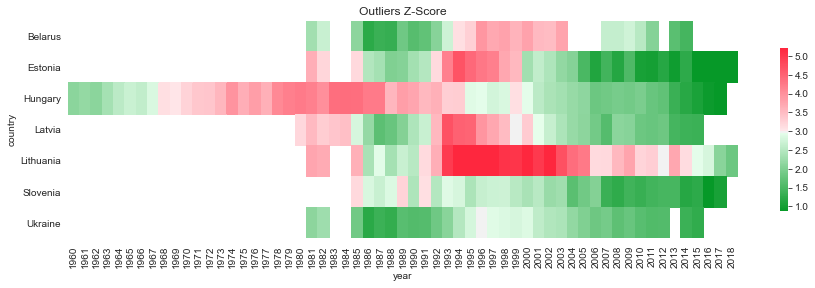

<Figure size 432x288 with 0 Axes>

In [93]:
suicide_outliers = df[df['country'].isin(outliers_countries)]
suicide_no_outliers = df[-df['country'].isin(outliers_countries)]

df=suicide_outliers[suicide_outliers['sex'] == 'male'].drop(['suicide_rate','sex'], axis=1).pivot_table(values='zscore',index='country',columns='year')

fig, ax = plt.subplots(figsize=(15,4))

# We want to shift the middle point of the color map to 3
divnorm = DivergingNorm(vmin=suicide_outliers['zscore'].min(), vcenter=3, vmax=suicide_outliers['zscore'].max())
rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)

g = sns.heatmap(
    ax=ax,
    robust=True,
    cbar_kws={"shrink": 0.75},
    norm=divnorm,
    cmap=rdgn,
    data=df
).set_title('Outliers Z-Score')

plt.xticks(rotation=90) 
plt.figure()

# We can now remove the zscore column for both datasets
del suicide_outliers['zscore']
del suicide_no_outliers['zscore'] 

We can notice how all the interested countries are ex eastern bloc nations. Historical and geographical closeness to the Russian Federation can lead us to believe that all this countries may share common factors leading to such high suicide rates.

The economic instability brought by the fall of the Soviet Union is undoubtedly the cause of most outliers being concetrated in the 90s (notice how the zscores tend to increase after 1991).

The high concentration that we see briefly at the beginning of the 80s is mostly correlated with the baltic states (Estonia/Latvia/Lithuania) and is probably caused by the social unrest that would lead to the Restoration of independence at the end of the same decade.

Another well documented factor related to this trend is the heavy alcohol consuption among the population of these countries (see: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1642767/)

We can now try to visually compare the shape of the line plotted by the mean suicide rates to the one plotted by our dataset that does not contain the outliers.

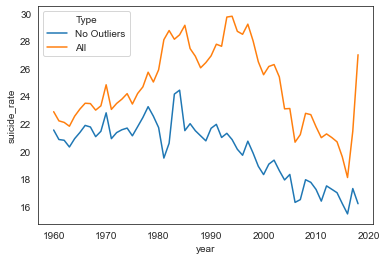

In [94]:
df_no_outliers = suicide_no_outliers[suicide_no_outliers['sex'] == 'male'].groupby(['year', 'sex']).suicide_rate.mean().reset_index()
df_no_outliers['Type'] = 'No Outliers'

df_all = suicide[suicide['sex'] == 'male'].groupby(['year', 'sex']).suicide_rate.mean().reset_index()
df_all['Type'] = 'All'

df = pd.concat([df_no_outliers, df_all])

sns.lineplot(
    x='year',
    y='suicide_rate',
    hue='Type',
    data=df
)

As expected, the line plotted by the dataset without outliers has noticeably smaller mean values.

At the same we can notice how the two lines follow a similar trend, with the only notable difference being the higher peak that we see at the beginning of the 90s caused by the fall of the Soviet Union.

## OECD Labour Market Data - Description

The OECD labour market dataset will contain data related to the following six features:

Unemployment rates on % of labour force (Lower is better)

Labour compensation indicated in average salary in US dollars (Higher is better, 1990-2019)

Hours worked indicated in Total hours worked / Total nr of active workers (Lower is better, 1950-2019)

Tax wedge on % of salary paid back in taxes (Lower is better, 2000-2019)

GPD per capita indicated in US dollars per capita (Higer is better, 1960-2019)

Adult education level indicated in % of people aged 25-64 with an education level that is below upper secondary (Lower is better, 1981-2019)

In [95]:
unemployment_rates = OECD_prepare_data(pd.read_csv('./source/labour/OECD_unemployment.csv'), 'unemployment_rates')
compensation = OECD_prepare_data(pd.read_csv('./source/labour/OECD_compensation.csv'), 'compensation')
hours = OECD_prepare_data(pd.read_csv('./source/labour/OECD_hours.csv'), 'hours_worked')
tax_wedge = OECD_prepare_data(pd.read_csv('./source/labour/OECD_taxWedge.csv'), 'tax_wedge')
gdp_per_capita = OECD_prepare_data(pd.read_csv('./source/labour/OECD_gdpPerCapita.csv'), 'GDP_per_capita')
adult_education = OECD_prepare_data(pd.read_csv('./source/labour/OECD_adult_education.csv'), 'adult_education')

## OECD Labour Market Data - Required actions

We will start off by joining the data coming these multiple csv file into a single dataset containing all the labour market features.

In [102]:
join_columns = ['country', 'year']

labour = unemployment_rates.merge(
    compensation,
    on = join_columns,
    how = 'left'
).merge(
    hours,
    on = join_columns,
    how = 'left'
).merge(
    tax_wedge,
    on = join_columns,
    how = 'left'
).merge(
    gdp_per_capita,
    on = join_columns,
    how = 'left'
).merge(
    adult_education,
    on = join_columns,
    how = 'left'
)

We can now proceed to change the countries two/three letter identifiers into their corresponding full-name values.

In [103]:
labour['country'] = labour['country'].apply(
    lambda x: pycountry.countries.get(alpha_3=x).name 
    if x.isalpha() and len(x) == 3
    else (pycountry.countries.get(alpha_2=x).name if len(x) == 2 and x.isalpha() else x)
)

Like in the suicide dataset, we can also filter out non european countries.

In [104]:
labour = labour[labour['country'].isin(euro_countries)]

Let's now take a brief look at the cleaned dataset.

In [106]:
labour.head()

,country,year,unemployment_rates,compensation,hours_worked,tax_wedge,GDP_per_capita,adult_education
52,Austria,1993,3.958333,45565.521090,NaN,NaN,21692.131966,NaN
53,Austria,1994,4.241667,46024.607042,NaN,NaN,22600.386244,NaN
54,Austria,1995,4.241667,46395.387695,1653.0,NaN,23653.653329,NaN
55,Austria,1996,4.733333,46048.905967,1683.0,NaN,24516.654846,NaN
56,Austria,1997,4.733333,45667.128225,1691.0,NaN,25418.154266,NaN


# CHAPTER 2 - DATA VISUALIZATION

## Suicide data - Visualization
To start off the visualizations of our suicide data, we are going to display a simple lineplot showing the differences between our two data sources.

The plot will show, for each year, the overall mean values of suicide rates.

Text(0.5, 1.0, 'Comparison of suicide datasets')

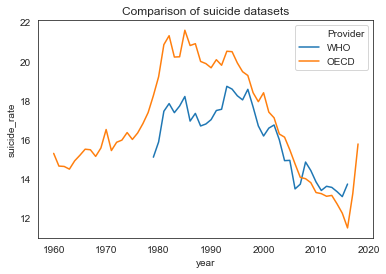

In [108]:
df1 = WHO_suicide.groupby(['year']).mean()
df1['Provider'] = 'WHO'

df2 = OECD_suicide.groupby(['year']).mean()
df2['Provider'] = 'OECD'

df = pd.concat([df1, df2]).reset_index()

sns.lineplot(
    x='year',
    y='suicide_rate',
    hue='Provider',
    markers='o',
    data=df
).set_title('Comparison of suicide datasets')

As we can see, the WHO datasets covers a smaller timespan in comparison to the OECD one and presents generally lower mean values for the years prior to 2005.

A first interesting information provided by this plot is that suicide rates are getting generally lower in comparison to the values we had during the 80s and 90s.

Another aspect we can notice from this visualization is a spike during the last years of the x axis in the OECD dataset.

This is probably due to a low number of countries providing data for the most recent years. This means that potentially a low number of countries with high suicide rates are strongly influencing the mean values during those years. To confirm this, we can plot the total number of countries providing their data for each year.

<Figure size 432x288 with 0 Axes>

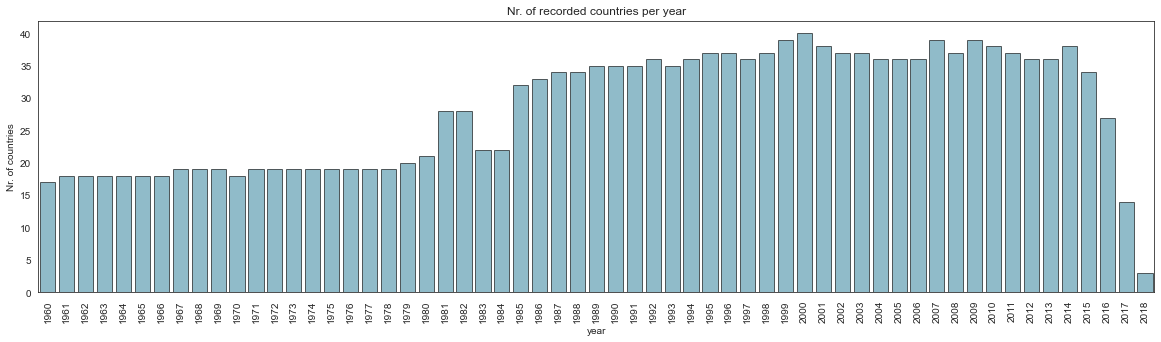

<Figure size 432x288 with 0 Axes>

In [37]:
df=suicide.drop(['sex'],axis=1).groupby(['country','year']).mean().reset_index()

fig, ax = plt.subplots(figsize=(20,5))

sns.countplot(
    ax=ax,
    x='year',
    color='#3697b5',
    edgecolor='black',
    alpha=0.6,
    data=df
).set_title('Nr. of recorded countries per year')

plt.ylabel('Nr. of countries')
plt.xticks(rotation=90) 
plt.figure()

As expected, we have an increasing pool of countries in the years going from 1979 to 2016 (which are the years covered by both datasets) and a drastic drop toward the end of the x axis.

Fortunately, for this project we are more interested in analyzing the correlation of suicide rates to the labour market features rather than doing an accurate representation of the suicide rates troughout the years. Because of this fact, even the years described by a small nr of countries are valuable to us.

In any case we can keep this fact in mind in order to have more accurate representation during the course of this chapter.

Next, we are going to take a look at the difference in suicide rates between sexes. We will start with a simple line plot.

Text(0.5, 1.0, 'Sex difference, line plot')

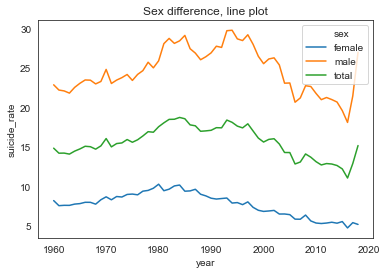

In [158]:
df = suicide.groupby(['year', 'sex']).suicide_rate.mean().reset_index()

sns.lineplot(
    x='year',
    y='suicide_rate',
    hue='sex',
    data=df
).set_title('Sex difference, line plot')

This visualization gives us a first insight on the strong difference between sexes in regards to suicide data.

To have a more impactful visual representation of this aspect of our data, we will draw a bar plot, comparing the male and female suicide rates during three years (1960, 1994, 2015).

We are using 2015 instead of 2018 (the most recent year in our dataset) beacuse we have established that 2018 does not have enough countries providing data to give us meaningful visual representation.

Text(0.5, 0.98, 'Sexes samples (Bar)')

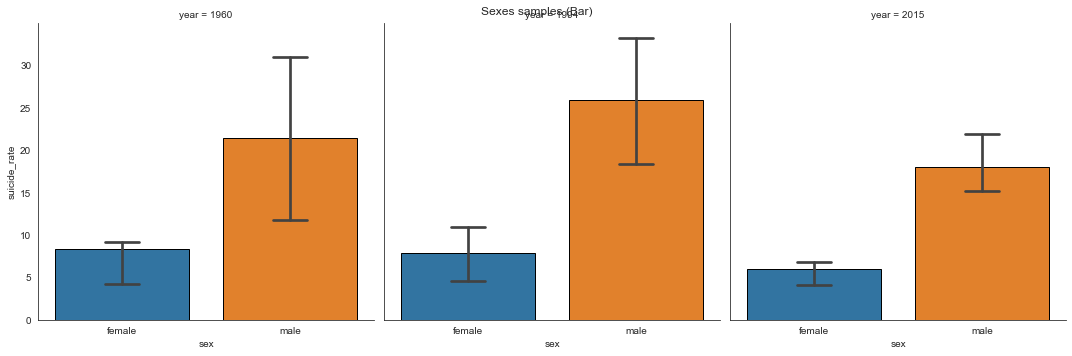

In [159]:
df = suicide[
        (suicide['year'] == suicide['year'].min()) | 
        (suicide['year'] == suicide['year'].median()) | 
        (suicide['year'] == 2015)
        ]

df = df[df['sex'] != 'total']

sns.catplot(
    x="sex", 
    y="suicide_rate", 
    col='year', 
    estimator=np.median,
    kind='bar',
    edgecolor='black',
    capsize=.2,
    data=df
).fig.suptitle('Sexes samples (Bar)')

This second bar plot reinforces the information that we received from the previous one, while also making it easier to immediately compare the difference in proportion between male and females.

As a last effort to visually represent this comparison, we will utilize a violin plot. This will provide us information similar to the ones we would get from a box plot while, at the same time, allowing us to see the kernel density curve (i.e. the full distribution) of our data.

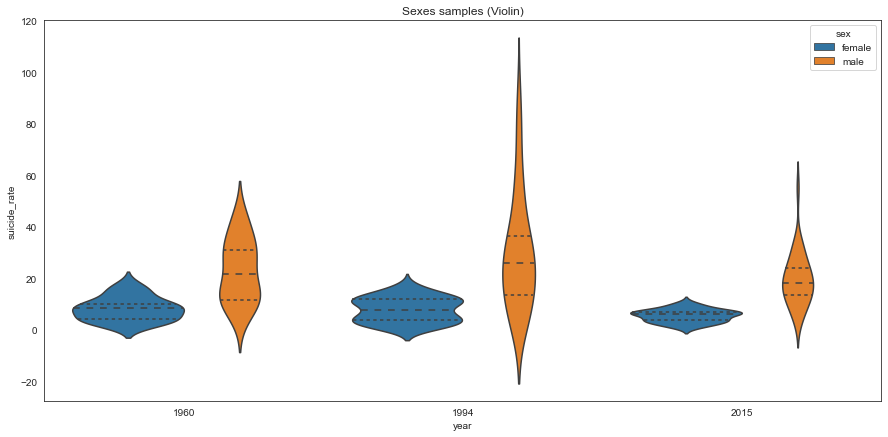

In [170]:
fig = plt.figure(figsize=(15, 7))

sns.violinplot(
    x='year',
    y='suicide_rate',
    hue='sex',
    inner='quartile',
    data=df
)

plt.title('Sexes samples (Violin)')
plt.show()

Another somewhat interesting information we may want to represent are the top countries in terms in mean suicide rates values.

We will achieve this by plotting an horizontal bar chart for both datasets with and without outliers.

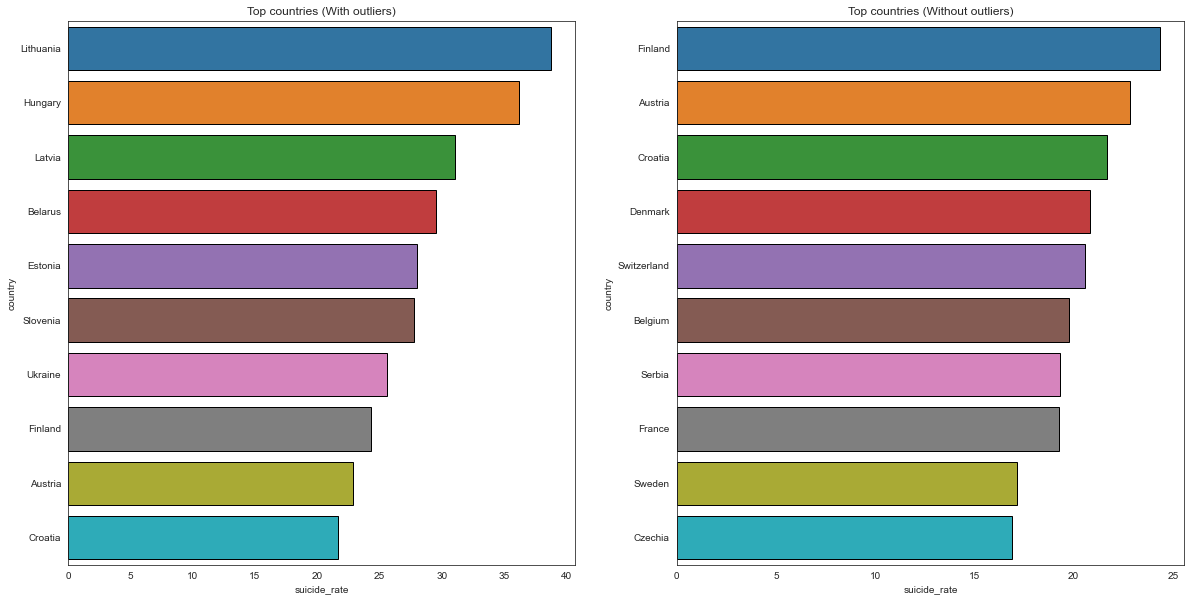

In [113]:
def plotTopCountries(data, titleStr, subplot):
    plt.subplot(subplot)
    plt.title('Top countries (' + titleStr + ')')
    df = data.groupby(['country']).suicide_rate.mean().nlargest(10).reset_index()

    sns.barplot(
        y="country", 
        x="suicide_rate",  
        orient='h',
        edgecolor='black',
        data=df,
    )

fig = plt.figure(figsize=(20, 10))
    
plotTopCountries(suicide, 'With outliers', 121)
plotTopCountries(suicide_no_outliers, 'Without outliers', 122)

plt.show()

At last, we can use a heatmap to have a final overall overview of our dataset.

<Figure size 432x288 with 0 Axes>

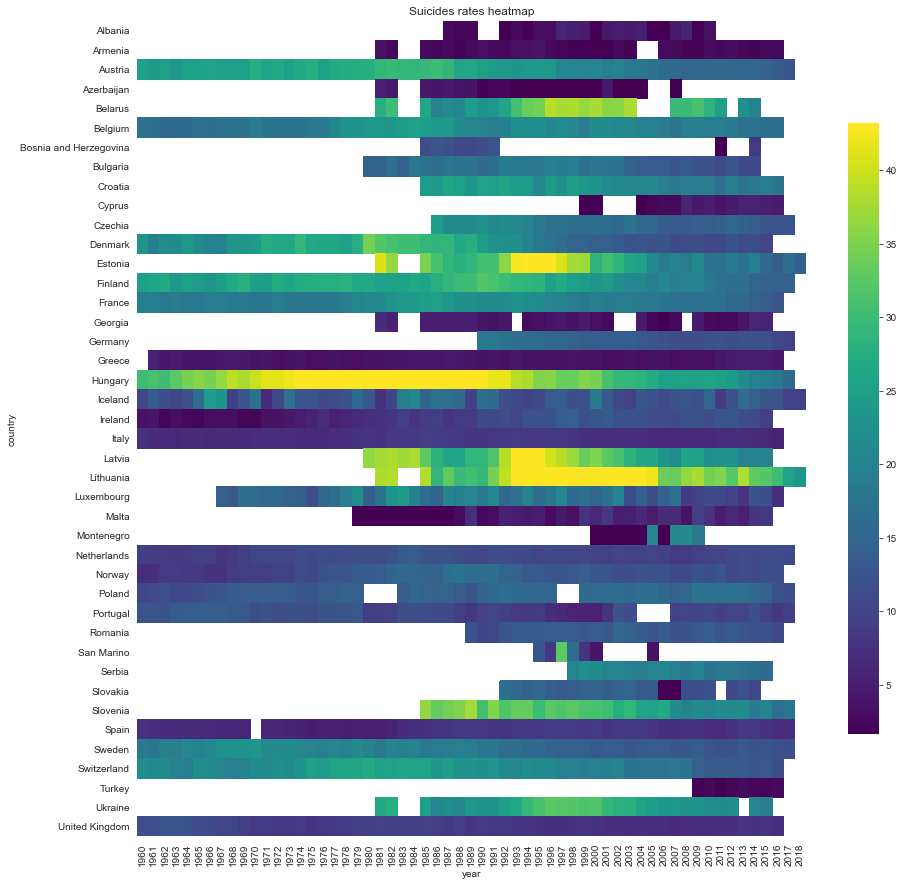

<Figure size 432x288 with 0 Axes>

In [114]:
df_heatmap = suicide[['country', 'year', 'suicide_rate']].pivot_table(values='suicide_rate',index='country',columns='year')

fig, ax = plt.subplots(figsize=(15,15))

g = sns.heatmap(
    ax=ax,
    robust=True,
    cmap='viridis',
    cbar_kws={"shrink": 0.75},
    data=df_heatmap
    ).set_title('Suicides rates heatmap')
plt.xticks(rotation=90) 
plt.figure()

## Labour market data - Visualization

We will now perform some (fairly brief) visualization on the labour market data before moving on to study the feature correlation between the two datasets.

Since we have yet to try to display data directly on a map, we will try to do this in this sub-chapter.



In [57]:
labour

,country,year,unemployment_rates,compensation,hours_worked,tax_wedge,GDP_per_capita,adult_education
52,Austria,1993,3.958333,45565.521090,NaN,NaN,21692.131966,NaN
53,Austria,1994,4.241667,46024.607042,NaN,NaN,22600.386244,NaN
54,Austria,1995,4.241667,46395.387695,1653.0,NaN,23653.653329,NaN
55,Austria,1996,4.733333,46048.905967,1683.0,NaN,24516.654846,NaN
56,Austria,1997,4.733333,45667.128225,1691.0,NaN,25418.154266,NaN
...,...,...,...,...,...,...,...,...
1257,Lithuania,2014,10.725000,22180.455295,1620.0,40.982305,28184.349133,8.824093
1258,Lithuania,2015,9.133333,23593.356366,1643.0,41.205057,28842.242746,8.644216
1259,Lithuania,2016,7.900000,24853.855693,1664.0,41.289383,30922.107210,7.484357
1260,Lithuania,2017,7.116667,26258.425699,1627.0,41.074653,33826.751533,7.171962


In [173]:
import geopandas as gpd

map_df = gpd.read_file('./source/shp/CNTR_BN_60M_2020_3035.shp')

map_df.plot()

ModuleNotFoundError: No module named 'geopandas'

# CHAPTER 3 - FEATURE CORRELATION

#3 Finding correlations in the processed data

In order to find the correlation between suicide rates and labour market features, we are going to merge out two datasets (by country and year).

In [120]:
merged_data = suicide.merge(
    labour,
    on = ['country', 'year'],
    how = 'left'
)

Plotting an heathmap is a good way to visually identify the level of correlation between the various features in our dataset. 

Given the fact the we know that sex plays a a major role in the likelihood of an individual of commiting suicide, we are going to plot the correlation values for male and females in two separate graphs.

Values close to -1 indicate a strong negative correlation.

Values close to +1 indicate a strong positive correlation.

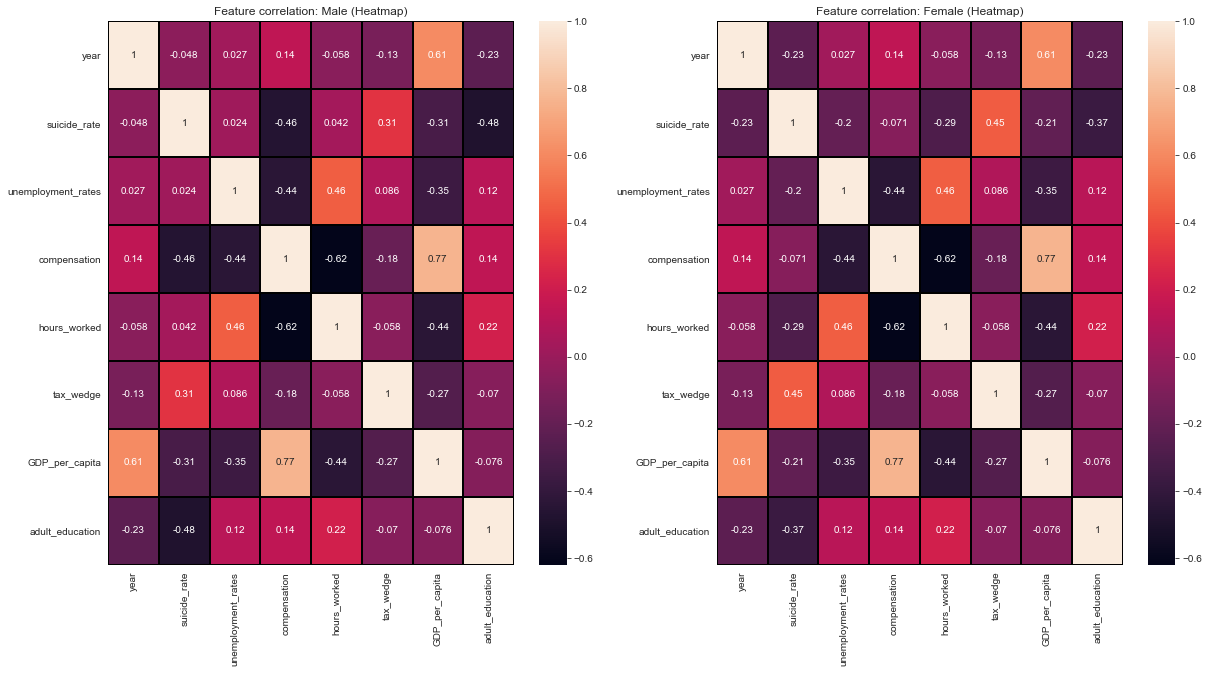

In [121]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title('Feature correlation: Male (Heatmap)')
sns.heatmap(merged_data[merged_data['sex'] == 'male'].corr(), linecolor='black', linewidths=1, annot=True)

plt.subplot(122)
plt.title('Feature correlation: Female (Heatmap)')
sns.heatmap(merged_data[merged_data['sex'] == 'female'].corr(), linecolor='black', linewidths=1, annot=True)

plt.show()

Another way to visually see these correlations (and to isolate the ones related to the suicide rate column) is to plot a vertical barchart with bars extending to the right side for positive correlation and to the left side for negative ones. 

Just like before, we are going to generate two different visualization based on sex.

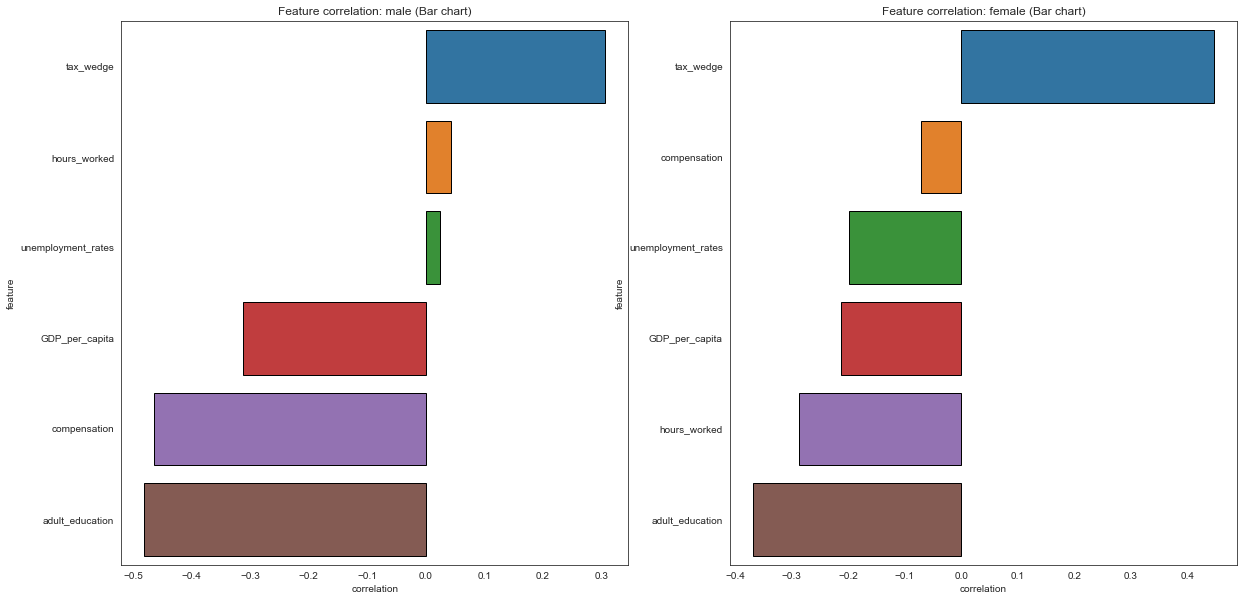

In [122]:
def buildCorrelation(data, sex, subplot):
    plt.subplot(subplot)
    plt.title('Feature correlation: ' + sex + ' (Bar chart)')

    ret = data[data['sex'] == sex].corr()['suicide_rate'].reset_index()
    ret.columns = ['feature', 'correlation']
    ret = ret[(ret['feature'] != 'suicide_rate') & (ret['feature'] != 'year')].sort_values(by=['correlation'], ascending = False)

    sns.barplot(
        y='feature', 
        x='correlation',  
        orient='h',
        edgecolor='black',
        data=ret
    )

fig = plt.figure(figsize=(20, 10))

buildCorrelation(merged_data, 'male', 121)
buildCorrelation(merged_data, 'female', 122)

plt.show()

At this point it may also be interesting to generate some plots that visually represent correlated features.

In order to avoid to overly cluttering our notebook with a very large number of representations, we are going to choose a single feature in the labour market data that we will visually compare to the suicide rates.

Keep in mind that the same (or very similar) visualization could be repeated for different labour market features.

## Suicides rates / GDP per capita - Visualizationing correlation

The correlation that we have chosen to visualize is the one between suicide rates and GDP per capita.

We will start with a very simple line plot that will host a single x axis (years) and two different y axis (suicide rate and GDP per capita). Both lines will represent the mean values derived by the grouping of multiple rows belonging to the same year in the original dataset.

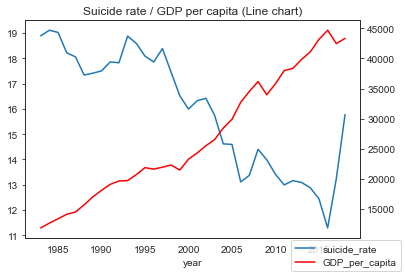

In [129]:
df = merged_data[['year', 'suicide_rate', 'GDP_per_capita']].groupby(['year']).mean().reset_index()
df = df[df['year'] >= 1983]

ax = df.plot(x='year', y='suicide_rate', legend=False)
ax2 = ax.twinx()
df.plot(x='year', y='GDP_per_capita', ax=ax2, legend=False, color='r')
ax.figure.legend(loc='lower right')

plt.title('Suicide rate / GDP per capita (Line chart)')
plt.show()

The negative correlation of this two features is already clearly visible. As the GDP per capita grows (red line) the suicide rates value shrinks (blue line).

An alternative way to visualize this trend while, at the same time, removing the chronological ordering present in the previous graph, is to plot the linear relationship between the two features as determined through (linear) regression.

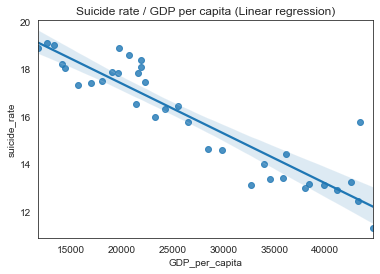

In [130]:
sns.regplot(
    x='GDP_per_capita',
    y='suicide_rate',
    data=df
)

plt.title('Suicide rate / GDP per capita (Linear regression)')
plt.show()

Once again, the negative correlation is clearly visible in our plot.

Another intersting visualization we can perform is the kernel density estimate of our two features. We can plot both kde, together with a shaded countour plot, using the jointplot function of Seaborn.

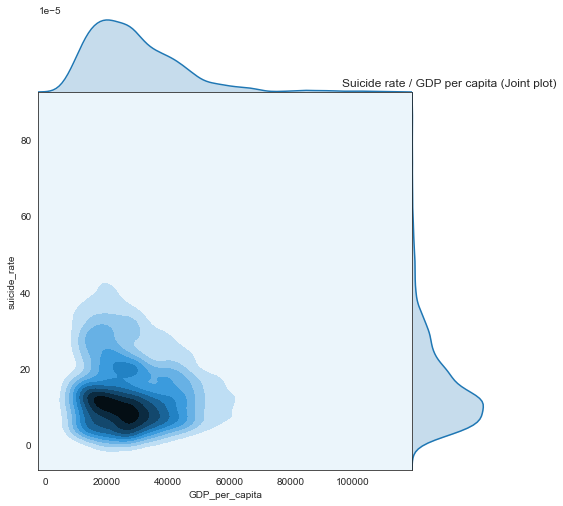

In [133]:
df = merged_data[['GDP_per_capita', 'year', 'suicide_rate']]

sns.jointplot(
    y='suicide_rate',
    x='GDP_per_capita', 
    fill='viridis',
    kind="kde", 
    height=7, 
    space=0,
    data=df
)

plt.title('Suicide rate / GDP per capita (Joint plot)')
plt.show()

As a last visualization step, it may be useful to represent both of our features, together with the year value, in a threedimensional context.

In order to do this we will create a 3D plot containing a temporal representation of the GDP per capita on the x and y axis, while moving the data related to the suicide rates on the z axis.

Additionally, we will divide the data color based on the sex column in our dataset.

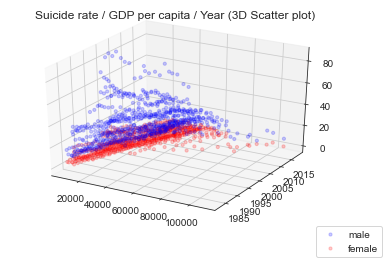

In [136]:
df_male = merged_data.loc[merged_data['sex'] == 'male']
df_female = merged_data.loc[merged_data['sex'] == 'female']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_male['GDP_per_capita'], df_male['year'], df_male['suicide_rate'], label="male", alpha=0.2, c="blue", s=10)
ax.scatter(df_female['GDP_per_capita'], df_female['year'], df_female['suicide_rate'], label="female", alpha=0.2, c="red", s=10)
ax.figure.legend(loc='lower right')

plt.title('Suicide rate / GDP per capita / Year (3D Scatter plot)')
plt.show()

# CHAPTER 4 - MACHINE LEARNING

Finally, we can move to the machine learning chapter of this notebook.

We will try to apply a set of ML models in order to see which one will be able to provide the best fit for the kind of predictions we want to make.

The final goal of this chapter would be to obtain a model that, provided a sex and a set of labour market features, will be able to estimate an expected suicide rate.

We will start by preparing our data for this process.

In [145]:
# Handling Na values
df = merged_data.copy().dropna() # TODO - Remove na?

# Encoding categorical data (sex)
le = LabelEncoder()
df.sex = le.fit_transform(df.sex)

# Removing year and country columns in order to have final models that only accept sex + labour market features
df = df.drop(['year', 'country'], axis=1)

# Feature scaling - Removing the median and scaling the data according to the quantile range 
cols_to_scale = ['suicide_rate','unemployment_rates','compensation','hours_worked','tax_wedge','GDP_per_capita','adult_education']

rc = RobustScaler()
df[cols_to_scale] = rc.fit_transform(df[cols_to_scale])

# Shuffling - 
# Important for cross_val_score (see: https://stats.stackexchange.com/questions/392115/why-is-cross-val-score-substantially-lower-than-score-or-roc-auc-score)
# (https://www.quora.com/When-training-Logistic-regression-should-I-shuffle-data-then-split-or-split-then-shuffle)
df = df.sample(frac=1)

y = df['suicide_rate'] # Target variable 
X = df.drop('suicide_rate',axis=1) # Predictors
X.shape, y.shape

((1251, 7), (1251,))

Now that our data is properly formatted for machine learning, we can proceed to split it into training and testing slices.

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 42)

Before fitting our model to our training data, we will use GridSearchCV to find the best hyperparameters that will be used to initialize said models.

In [147]:
folds = 5

def autoGridSeach(regressor, parms, name):
    grid_search = GridSearchCV(
        estimator = regressor,
        param_grid = parms,
        cv = folds,
        n_jobs = -1,
        verbose = 0,
        refit = False # TODO - See if correct
    )

    grid_search.fit(X_train, y_train)

    print(name + ': ' + str(grid_search.best_params_))

'''
autoGridSeach(
    KNeighborsRegressor(),
    {'n_neighbors': np.arange(1, 12, 2), 'weights': ['uniform', 'distance']},
    'K Neighbors'
)

autoGridSeach(
    DecisionTreeRegressor(),
    {'criterion': ['mse', 'mae'], 'min_samples_split': [10, 20, 40], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40, 100],'max_leaf_nodes': [5, 20, 100]},
    'Decision tree'
)

autoGridSeach(
    AdaBoostRegressor(),
    {'n_estimators': [50, 100], 'learning_rate' : [0.01, 0.05, 0.1, 0.5], 'loss' : ['linear', 'square', 'exponential']},
    'Ada Boost'
)

autoGridSeach(
    RandomForestRegressor(),
    {'bootstrap': [True], 'max_depth': [80, 90, 100, 110],'max_features': [2, 3],'min_samples_leaf': [3, 4, 5],'min_samples_split': [8, 10, 12],'n_estimators': [100, 200, 300, 1000]},
    'Random forest'
)

autoGridSeach(
    XGBRegressor(),
    {'nthread':[4], 'learning_rate': [.03, 0.05, .07], 'max_depth': [5, 6, 7], 'min_child_weight': [4], 'silent': [1], 'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [500]},
    'XGBoost'
)

autoGridSeach(
    GradientBoostingRegressor(),
    {'n_estimators':[100,500], 'learning_rate': [0.1,0.05,0.02], 'max_depth':[4],  'min_samples_leaf':[3],  'max_features':[1.0]}, 
    'Gradient boosting'
)

autoGridSeach(
    LGBMRegressor(),
    {'num_leaves': [7, 14, 21, 28, 31, 50], 'learning_rate': [0.1, 0.03, 0.003], 'max_depth': [-1, 3, 5], 'n_estimators': [50, 100, 200, 500]},
    'LGBM'
)

autoGridSeach(
    SVR(),
    {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},
    'SVR (SVM)'
)
'''

"\nautoGridSeach(\n    KNeighborsRegressor(),\n    {'n_neighbors': np.arange(1, 12, 2), 'weights': ['uniform', 'distance']},\n    'K Neighbors'\n)\n\nautoGridSeach(\n    DecisionTreeRegressor(),\n    {'criterion': ['mse', 'mae'], 'min_samples_split': [10, 20, 40], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40, 100],'max_leaf_nodes': [5, 20, 100]},\n    'Decision tree'\n)\n\nautoGridSeach(\n    AdaBoostRegressor(),\n    {'n_estimators': [50, 100], 'learning_rate' : [0.01, 0.05, 0.1, 0.5], 'loss' : ['linear', 'square', 'exponential']},\n    'Ada Boost'\n)\n\nautoGridSeach(\n    RandomForestRegressor(),\n    {'bootstrap': [True], 'max_depth': [80, 90, 100, 110],'max_features': [2, 3],'min_samples_leaf': [3, 4, 5],'min_samples_split': [8, 10, 12],'n_estimators': [100, 200, 300, 1000]},\n    'Random forest'\n)\n\nautoGridSeach(\n    XGBRegressor(),\n    {'nthread':[4], 'learning_rate': [.03, 0.05, .07], 'max_depth': [5, 6, 7], 'min_child_weight': [4], 'silent': [1], 'subsample': [0.7]

Finally, we can fit our models (initialized with the hyperparameters obtained in the previous block) to our training data.

Then, we will use the .predict() function on both our training and testing sets, this will allow us to compute the accuracy (R2 score) of our model for both our training and testing
slices.

Additionally, we will also compute the n-fold cross validation score and the train and test root mean squared errors.

In [148]:
results = pd.DataFrame(columns=['Model', 'Train score', 'Test score', 'Train RMSE', 'Test RMSE', 'Cross val score (' + str(folds) + ' folds)'])

def autoFit(regressor, idStr):
    regressor.fit(X_train, y_train)

    y_test_pred = regressor.predict(X_test)
    y_train_pred = regressor.predict(X_train)

    mean_cross_val_score = cross_val_score(regressor, X, y, cv=folds).mean()

    # Alternative
    # train_score = regressor.score(X_train, y_train)
    # test_score = regressor.score(X_test, y_test)

    train_score = r2_score(y_train, y_train_pred)
    test_score = r2_score(y_test, y_test_pred)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results.loc[-1] = [idStr, train_score, test_score, rmse_train, rmse_test, mean_cross_val_score]
    results.index = results.index + 1

    '''
    X_ax = range(len(y_test))
    plt.plot(X_ax, y_test, label='test')
    plt.plot(X_ax, y_test_pred, label='prediction')
    plt.title(idStr)
    plt.legend()
    plt.show()
    '''

    return regressor

linear_Regressor = autoFit(
    LinearRegression(), 
    'Linear'
)

kneighbors_Regressor = autoFit(
    KNeighborsRegressor(
        n_neighbors=3,
        weights='distance'
    ),
    'K Neighbors'
)

decision_tree_regressor = autoFit(
    DecisionTreeRegressor(
        criterion= 'mse', 
        max_depth= 8, 
        max_leaf_nodes= 100, 
        min_samples_leaf= 20, 
        min_samples_split= 10
    ),
    'Decision Tree'
)

ada_boost_regressor = autoFit(
    AdaBoostRegressor(
        learning_rate= 0.1,
        n_estimators=100, 
        loss='exponential'
    ),
    'DT (Ada Boost)'
)

random_forest_regressor = autoFit(
    RandomForestRegressor(
        bootstrap= True,
        max_depth= 90,
        max_features= 3,
        min_samples_leaf= 3, 
        min_samples_split= 8,
        n_estimators= 100
    ),
    'Random forest'
)

xgb_boost_regressor = autoFit(
    XGBRegressor(
        colsample_bytree= 0.7,
        learning_rate= 0.07,
        max_depth= 6,
        min_child_weight= 4,
        n_estimators= 500,
        nthread= 4,
        subsample= 0.7
    ),
    'XGB'
)

gradient_boosting_regressor = autoFit(
    GradientBoostingRegressor(
        learning_rate= 0.1,
        max_depth= 4, 
        max_features= 1.0,
        min_samples_leaf= 3,
        n_estimators= 500
    ),
    'Gradient Boosting'
)

lgbm_regressor = autoFit(
    LGBMRegressor(
        learning_rate= 0.1, 
        max_depth= -1, 
        n_estimators= 500, 
        num_leaves= 7
    ),
    'Light GBM'
)

results.sort_values(by=['Test score'])

,Model,Train score,Test score,Train RMSE,Test RMSE,Cross val score (5 folds)
7,Linear,0.263612,0.295733,0.790439,0.735129,0.262466
5,Decision Tree,0.803894,0.643130,0.407907,0.523299,0.773281
4,DT (Ada Boost),0.752249,0.662594,0.458483,0.508828,0.672274
3,Random forest,0.942539,0.885685,0.220801,0.296173,0.890746
6,K Neighbors,1.000000,0.891579,0.000000,0.288437,0.887749
1,Gradient Boosting,0.997456,0.945207,0.046463,0.205048,0.950653
0,Light GBM,0.988883,0.953398,0.097121,0.189102,0.942543
2,XGB,0.997025,0.954854,0.050244,0.186124,0.944773


We can now take our best model and visualize the importance of the different features.

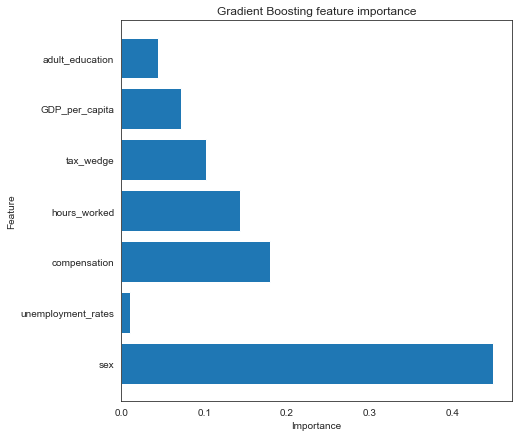

In [149]:
plt.figure(figsize=(7,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), gradient_boosting_regressor.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting feature importance')
plt.show()

As an additional step, we can serialize our best model into a .pkl file.

In [150]:
'''
# Serialization
with open('suicides_model.pkl', 'wb') as pickle_file:
       joblib.dump(xgb_boost_regressor, 'suicides_model.pkl')
'''

"\n# Serialization\nwith open('suicides_model.pkl', 'wb') as pickle_file:\n       joblib.dump(xgb_boost_regressor, 'suicides_model.pkl')\n"

In [151]:
'''
df[(df['country'] == 1) & (df['year'] == 2007)]
test = X_test[(X_test['country'] == 1) & (X_test['year'] == 2007)]
test
gradient_boosting_regressor.predict(test)
'''

"\ndf[(df['country'] == 1) & (df['year'] == 2007)]\ntest = X_test[(X_test['country'] == 1) & (X_test['year'] == 2007)]\ntest\ngradient_boosting_regressor.predict(test)\n"

# CHAPTER 5 - RESULTS & CONCLUSIONS

We will use this chapter to briefly wrap up what w